In [3]:
from math import sin, cos
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import pandas as pd
#import cv2, json
#from PIL import Image, ImageDraw

#import torchvision
import time
import os,sys,copy,pdb,time,argparse

import torch
#from torch.utils.data import Dataset, DataLoader
#from torchvision import datasets, models, transforms

PROJ_ROOT="/gpfs/home/s4s004/vanstee/2020-11-wisc"
sys.path.append(os.path.abspath(PROJ_ROOT + "/pytorch-retinanet"))

#import retinanet.model as model
os.chdir(PROJ_ROOT)

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
print('CUDA available: {}  Using device {}'.format(torch.cuda.is_available(), os.environ['CUDA_VISIBLE_DEVICES']))

# utility print function
def nprint(mystring) :
    print("**{}** : {}".format(sys._getframe(1).f_code.co_name,mystring))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

CUDA available: True  Using device 2


In [6]:
# !conda install -y -c conda-forge pytest-shutil
#!conda install -y -c anaconda pathlib

# Dataset
For this example we will be using the dataset located here .  It provides a set of ground truth labels for the first 4500 frames, and you can evaluate your model on the last 3000 frames.

https://academictorrents.com/details/35e83806d9362a57be736f370c821960eb2f2a01

# Prepare Oxford dataset for RetinaNet Training
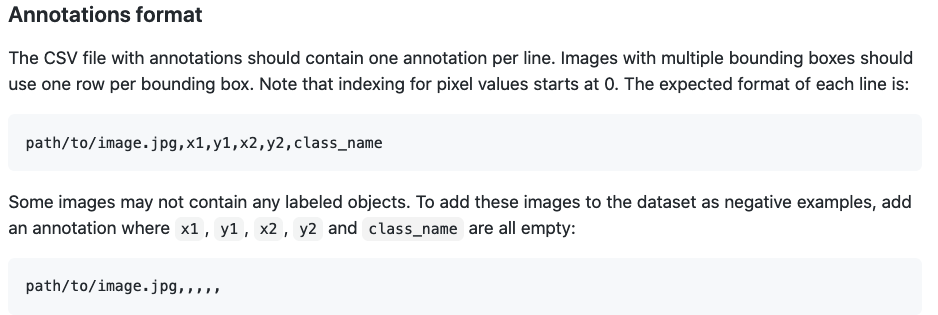


In [2]:
!ls /gpfs/home/s4s004/vanstee/2020-11-wisc/data/OxfordTown-Top-labelled-large | head -n 50

0000_stitch.jpg
0001_stitch.jpg
0002_stitch.jpg
0003_stitch.jpg
0004_stitch.jpg
0005_stitch.jpg
0006_stitch.jpg
0007_stitch.jpg
0008_stitch.jpg
0009_stitch.jpg
0010_stitch.jpg
0011_stitch.jpg
0012_stitch.jpg
0013_stitch.jpg
0014_stitch.jpg
0015_stitch.jpg
0016_stitch.jpg
0017_stitch.jpg
0018_stitch.jpg
0019_stitch.jpg
0020_stitch.jpg
0021_stitch.jpg
0022_stitch.jpg
0023_stitch.jpg
0024_stitch.jpg
0025_stitch.jpg
0026_stitch.jpg
0027_stitch.jpg
0028_stitch.jpg
0029_stitch.jpg
0030_stitch.jpg
0031_stitch.jpg
0032_stitch.jpg
0033_stitch.jpg
0034_stitch.jpg
0035_stitch.jpg
0036_stitch.jpg
0037_stitch.jpg
0038_stitch.jpg
0039_stitch.jpg
0040_stitch.jpg
0041_stitch.jpg
0042_stitch.jpg
0043_stitch.jpg
0044_stitch.jpg
0045_stitch.jpg
0046_stitch.jpg
0047_stitch.jpg
0048_stitch.jpg
0049_stitch.jpg
ls: write error: Broken pipe


In [3]:
!cat /gpfs/home/s4s004/vanstee/2020-11-wisc/data/OxfordTown-Top-labelled-large/labels.csv | head -n 20

/gpfs/home/s4s004/vanstee/2020-11-wisc/data/OxfordTown-Top-labelled-large/0000_stitch.jpg,236,770,372,1101,person
/gpfs/home/s4s004/vanstee/2020-11-wisc/data/OxfordTown-Top-labelled-large/0000_stitch.jpg,286,291,371,493,person
/gpfs/home/s4s004/vanstee/2020-11-wisc/data/OxfordTown-Top-labelled-large/0000_stitch.jpg,287,231,366,416,person
/gpfs/home/s4s004/vanstee/2020-11-wisc/data/OxfordTown-Top-labelled-large/0000_stitch.jpg,720,221,787,408,person
/gpfs/home/s4s004/vanstee/2020-11-wisc/data/OxfordTown-Top-labelled-large/0000_stitch.jpg,794,235,861,428,person
/gpfs/home/s4s004/vanstee/2020-11-wisc/data/OxfordTown-Top-labelled-large/0000_stitch.jpg,876,392,956,628,person
/gpfs/home/s4s004/vanstee/2020-11-wisc/data/OxfordTown-Top-labelled-large/0000_stitch.jpg,656,995,792,1387,person
/gpfs/home/s4s004/vanstee/2020-11-wisc/data/OxfordTown-Top-labelled-large/0000_stitch.jpg,1607,602,1717,893,person
/gpfs/home/s4s004/vanstee/2020-11-wisc/data/OxfordTown-Top-labelled-large/0000_stitch.jpg,16

# Visualize Labels

In [30]:
def draw_simple_boxes(img, bboxes, label_names) :
    for j in range(len(bboxes)):
        bbox = bboxes[j]
        #print(bbox)
        x1 = int(bbox[0])
        y1 = int(bbox[1])
        x2 = int(bbox[2])
        y2 = int(bbox[3])
        label_name = label_names[j][0]
        print(x1,y1,x2,y2,label_name)
        draw_caption(img, (x1, y1, x2, y2), label_name)
        cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=5)

def draw_caption(image, box, caption):

    b = np.array(box).astype(int)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1)

        

In [13]:
import pandas as pd
df = pd.read_csv('/gpfs/home/s4s004/vanstee/2020-11-wisc/data/OxfordTown-Top-labelled-large/labels.csv', header=None)
df.columns = ['path','x1','y1','x2','y2','class']

In [14]:
frame0_df = df[df["path"] == '/gpfs/home/s4s004/vanstee/2020-11-wisc/data/OxfordTown-Top-labelled-large/0000_stitch.jpg']

In [17]:
bboxes = frame0_df[['x1','y1','x2','y2']].values
classifications = frame0_df[['class']].values

(1080, 1920, 3)
236 770 372 1101 person
286 291 371 493 person
287 231 366 416 person
720 221 787 408 person
794 235 861 428 person
876 392 956 628 person
656 995 792 1387 person
1607 602 1717 893 person
1616 890 1748 1278 person
1790 174 1877 359 person
1645 113 1714 278 person
1460 29 1512 167 person
1361 10 1409 143 person
890 74 943 221 person


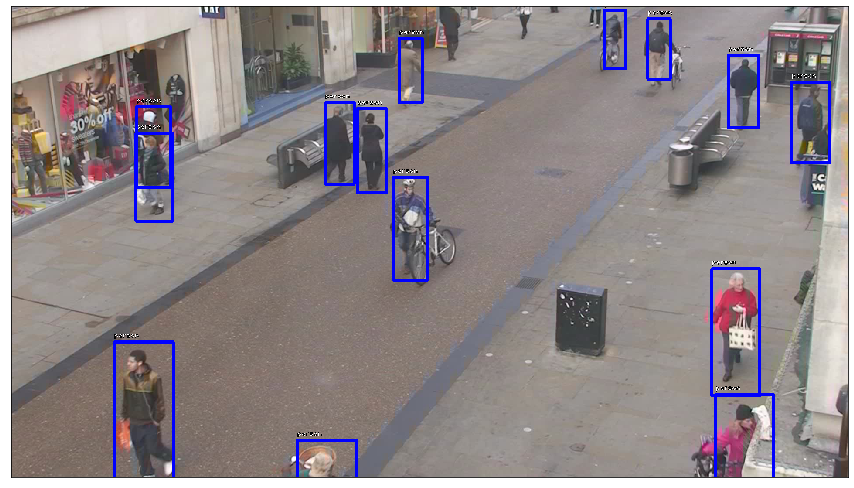

In [39]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Load an color image in grayscale
img = cv2.imread('/gpfs/home/s4s004/vanstee/2020-11-wisc/data/OxfordTown-Top-labelled-large/0000_stitch.jpg',1)
img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)

print(img.shape)
plt.figure(figsize=(15,15))

plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis

print("Bounding Box Pixel Coordinates")
draw_simple_boxes(img, bboxes, classifications) 
plt.imshow(img)
plt.show()


# Train Retinanet [Large-Top]

In [ ]:
!(python {PROJ_ROOT}/pytorch-retinanet/train.py  \
 --dataset csv \
 --csv_train   {PROJ_ROOT}/data/OxfordTown-Top-labelled-large/labels.csv \
 --csv_classes {PROJ_ROOT}/data/OxfordTown-Top-labelled-large/lookup.csv \
 --csv_val     {PROJ_ROOT}/data/OxfordTown-Top-labelled-large/val_labels.csv)

#/gpfs/home/s4s004/vanstee/2020-11-wisc/data/OxfordTown-Top-labelled-large

CUDA available: True
Num training images: 4282
Epoch: 0 | Iteration: 0 | Classification loss: 1.12867 | Regression loss: 1.03245 | Running loss: 2.16112
Epoch: 0 | Iteration: 1 | Classification loss: 1.10979 | Regression loss: 0.99063 | Running loss: 2.13077
Epoch: 0 | Iteration: 2 | Classification loss: 1.09547 | Regression loss: 0.95755 | Running loss: 2.10485
Epoch: 0 | Iteration: 3 | Classification loss: 1.06227 | Regression loss: 0.95376 | Running loss: 2.08265
Epoch: 0 | Iteration: 4 | Classification loss: 1.01570 | Regression loss: 0.90738 | Running loss: 2.05074
Epoch: 0 | Iteration: 5 | Classification loss: 0.97354 | Regression loss: 0.90862 | Running loss: 2.02264
Epoch: 0 | Iteration: 6 | Classification loss: 0.90227 | Regression loss: 0.92558 | Running loss: 1.99481
Epoch: 0 | Iteration: 7 | Classification loss: 0.80227 | Regression loss: 0.90572 | Running loss: 1.95896
Epoch: 0 | Iteration: 8 | Classification loss: 0.70894 | Regression loss: 0.92647 | Running loss: 1.92301

In [56]:
!(python {PROJ_ROOT}/pytorch-retinanet/visualize.py \
--dataset csv \
--csv_classes {PROJ_ROOT}/data/OxfordTown-Top-labelled-large/lookup.csv \
--csv_val {PROJ_ROOT}/data/OxfordTown-Top-labelled-large/labels.csv \
--model  {PROJ_ROOT}/csv_retinanet_48.pt)

CUDA available: True
Traceback (most recent call last):
  File "/gpfs/home/s4s004/vanstee/2020-11-wisc/pytorch-retinanet/visualize.py", line 108, in <module>
    main()
  File "/gpfs/home/s4s004/vanstee/2020-11-wisc/pytorch-retinanet/visualize.py", line 41, in main
    dataset_val = CSVDataset(train_file=parser.csv_train, class_list=parser.csv_classes, transform=transforms.Compose([Normalizer(), Resizer()]))
AttributeError: 'Namespace' object has no attribute 'csv_train'


# Train Retinanet [MVI]

In [30]:
!(python {PROJ_ROOT}/pytorch-retinanet/train.py  \
 --dataset csv \
 --csv_train   {PROJ_ROOT}/data/OxfordTown-Mvi-labelled-small.convert/objdet/labels.csv \
 --csv_classes {PROJ_ROOT}/data/OxfordTown-Mvi-labelled-small.convert/objdet/lookup.csv \
 --csv_val     {PROJ_ROOT}/data/OxfordTown-Mvi-labelled-small.convert/objdet/labels.csv)


CUDA available: True
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to ./resnet50-19c8e357.pth
100%|██████████████████████████████████████| 97.8M/97.8M [00:03<00:00, 26.7MB/s]
Num training images: 26
Epoch: 0 | Iteration: 0 | Classification loss: 1.12876 | Regression loss: 0.99133 | Running loss: 2.12009
Epoch: 0 | Iteration: 1 | Classification loss: 1.11422 | Regression loss: 1.00181 | Running loss: 2.11806
Epoch: 0 | Iteration: 2 | Classification loss: 1.09595 | Regression loss: 1.00096 | Running loss: 2.11101
Epoch: 0 | Iteration: 3 | Classification loss: 1.06923 | Regression loss: 0.97611 | Running loss: 2.09459
Epoch: 0 | Iteration: 4 | Classification loss: 1.03283 | Regression loss: 0.96819 | Running loss: 2.07588
Epoch: 0 | Iteration: 5 | Classification loss: 0.99523 | Regression loss: 0.92372 | Running loss: 2.04972
Epoch: 0 | Iteration: 6 | Classification loss: 0.91296 | Regression loss: 0.93609 | Running loss: 2.02106
Epoch: 0 | Iteration: 7 | Classi

In [ ]:
# person: 0.9870517394862597
# Epoch: 99 | Iteration: 0 | Classification loss: 0.00985 | Regression loss: 0.06262 | Running loss: 0.12957
# Epoch: 99 | Iteration: 1 | Classification loss: 0.00690 | Regression loss: 0.05775 | Running loss: 0.12925
# Epoch: 99 | Iteration: 2 | Classification loss: 0.00823 | Regression loss: 0.05399 | Running loss: 0.12905
# Epoch: 99 | Iteration: 3 | Classification loss: 0.00810 | Regression loss: 0.06349 | Running loss: 0.12880
# Epoch: 99 | Iteration: 4 | Classification loss: 0.00646 | Regression loss: 0.04018 | Running loss: 0.12848
# Epoch: 99 | Iteration: 5 | Classification loss: 0.00702 | Regression loss: 0.05692 | Running loss: 0.12813
# Epoch: 99 | Iteration: 6 | Classification loss: 0.00689 | Regression loss: 0.05771 | Running loss: 0.12786
# Epoch: 99 | Iteration: 7 | Classification loss: 0.01481 | Regression loss: 0.08008 | Running loss: 0.12764
# Epoch: 99 | Iteration: 8 | Classification loss: 0.00868 | Regression loss: 0.06731 | Running loss: 0.12742
# Epoch: 99 | Iteration: 9 | Classification loss: 0.01154 | Regression loss: 0.06726 | Running loss: 0.12732
# Epoch: 99 | Iteration: 10 | Classification loss: 0.01055 | Regression loss: 0.06005 | Running loss: 0.12708
# Epoch: 99 | Iteration: 11 | Classification loss: 0.00804 | Regression loss: 0.06489 | Running loss: 0.12690
# Epoch: 99 | Iteration: 12 | Classification loss: 0.00791 | Regression loss: 0.06884 | Running loss: 0.12673
# Evaluating dataset
# 26/26
# mAP:
# person: 0.9874716050718271


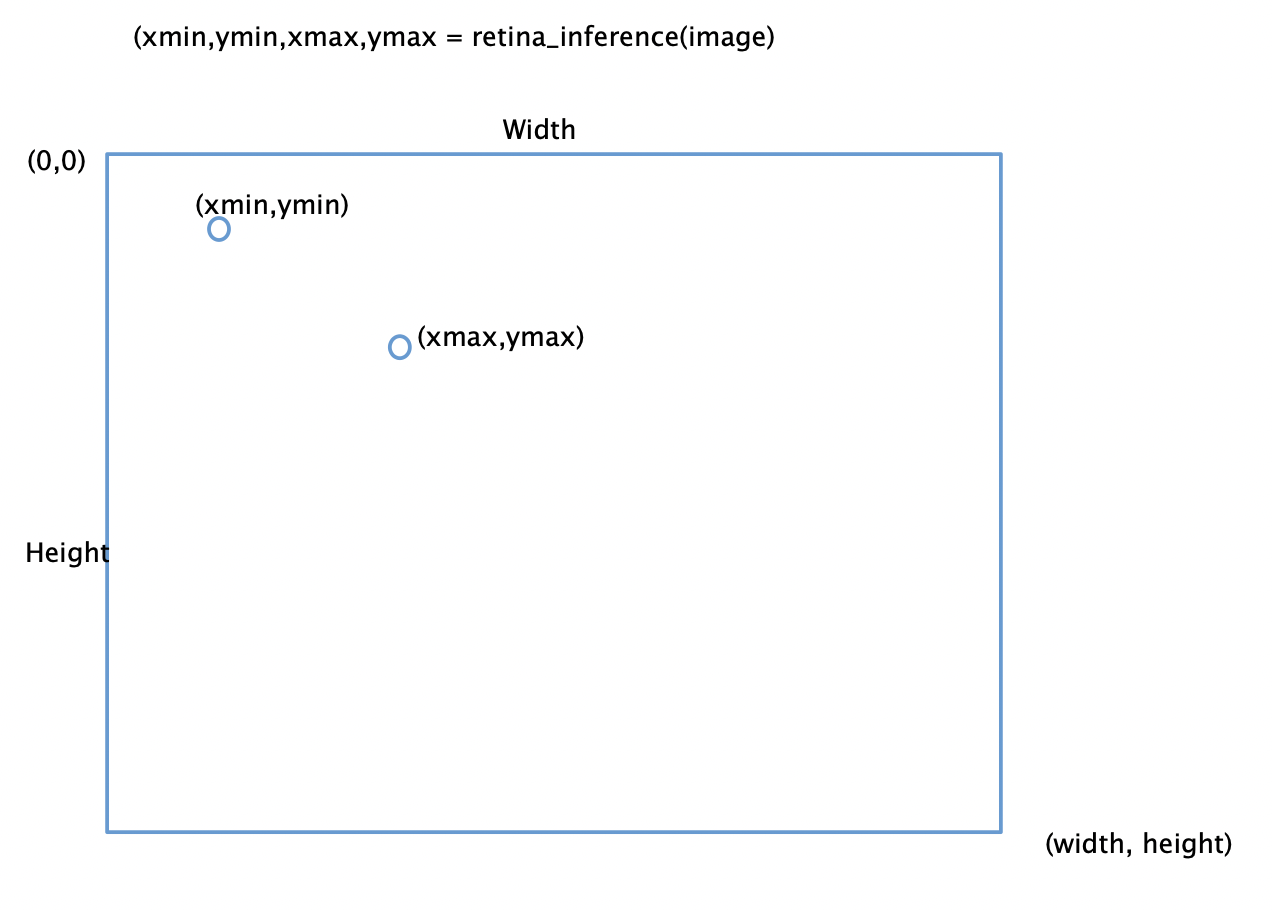

In [ ]:
X=money_df[['xmin','ymin','xmax','ymax']] # Matches retinanet implementation
Y=money_df[['x','y','z']]
display(X.head(20))
display(Y.head(20))

In [ ]:
## Plot scatters

fig, axes = plt.subplots(nrows=3, ncols=2)
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()
ax0.scatter(X['xmax'],Y['x'])
ax0.legend(prop={'size': 10})
ax0.set_title('xmax vs x')

ax1.scatter(X['ymax'],Y['x'])
ax1.legend(prop={'size': 10})
ax1.set_title('ymax vs x')

ax2.scatter(X['xmax'],Y['y'])
ax2.legend(prop={'size': 10})
ax2.set_title('xmax vs y')

ax3.scatter(X['ymax'],Y['y'])
ax3.legend(prop={'size': 10})
ax3.set_title('ymax vs y')

ax4.scatter(X['xmax'],Y['z'])
ax4.legend(prop={'size': 10})
ax4.set_title('xmax vs z')

ax5.scatter(X['ymax'],Y['z'])
ax5.legend(prop={'size': 10})
ax5.set_title('ymax vs z')

# ax1.hist(X_train.numpy())
# ax1.legend(prop={'size': 10})
# ax1.set_title('Normalized boxes')
# 
# ax2.hist(X_test.numpy(),label=['xmax','ymax','xmin','ymin'])
# ax2.legend(prop={'size': 10})
# ax2.set_title('Test normalized boxes')
# 
# ax3.hist(y_train.numpy(),label=['x','y','z'])
# ax3.legend(prop={'size': 10})
# ax3.set_title('train xyz')
fig.tight_layout()
plt.show()

In [ ]:
# Initialize with Xavier normal distribuition        
def weights_xavier(m):
    if isinstance(m, nn.Conv2d):
        xavier_normal_(m.weight.data)
    elif isinstance(m, nn.Linear) :
        xavier_normal_(m.weight.data)
        m.bias.data.fill_(0)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

Xnp = np.array(X.values,dtype=np.float32)
Ynp = np.array(Y.values,dtype=np.float32)
X_train, X_test, y_train, y_test = train_test_split(Xnp, Ynp, test_size=0.33, random_state=42)
scaler.fit(X_train)
print(scaler.mean_)
print(scaler.var_)

X_train =scaler.transform(X_train)
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)

X_test =scaler.transform(X_test)
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)


In [ ]:
## Plot distributions

fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flatten()
ax0.hist(Xnp,label=['xmin','ymin','xmax','ymax'])
ax0.legend(prop={'size': 10})
ax0.set_title('Unnormalized boxes')

ax1.hist(X_train.numpy())
ax1.legend(prop={'size': 10})
ax1.set_title('Normalized boxes')

ax2.hist(X_test.numpy(),label=['xmin','ymin','xmax','ymax'])
ax2.legend(prop={'size': 10})
ax2.set_title('Test normalized boxes')

ax3.hist(y_train.numpy(),label=['x','y','z'])
ax3.legend(prop={'size': 10})
ax3.set_title('train xyz')
fig.tight_layout()
plt.show()

In [ ]:
batch_size = 8
num_examples = X_train.size()[0]
num_batches = int(num_examples / batch_size)
#Xtt[0:4,:]

In [ ]:
# run the main training loop
epochs=3000
log_interval=20

net = Net()
print(net)
net.apply(weights_xavier)
# create a stochastic gradient descent optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.00001)
# create a loss function
criterion = nn.MSELoss()

# 0.828509!

In [ ]:
epochs = 1000
for epoch in range(epochs):
    tr_loss=0
    for i in range(num_batches):
        data = X_train[i*4:i*4+batch_size]
        target = y_train[i*4:i*4+batch_size]
        #print(data)
        #print(target)
        
        optimizer.zero_grad()
        yhat = net(data)
        #print(yhat)
        #break
        loss = criterion(yhat, target)
        tr_loss += loss
        loss.backward()
        optimizer.step()
    
    # Validataion ..
    if epoch % log_interval == 0:
        yhat_val = net(X_test)
        val_loss = criterion(yhat_val,y_test)
        val_loss = val_loss/len(X_test)
        tr_loss = tr_loss/len(X_train)
        print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(
                    epoch, i * len(data), len(X_train,),
                    100. * i/num_batches, tr_loss, val_loss),end=' ', flush=True)

        
# Previous ..        
# Train Epoch: 2980 [168/177 (95%)]	Train Loss: 3.280712	Val Loss: 0.583376


In [ ]:
yhat = net(X_test)
print(X_test[0:2])
print(yhat[0:10])
print(y_test[0:10])


In [ ]:
yhat = net(X_train)
print(X_train[0:2])
print(yhat[0:2])
print(y_train[0:2])
    

In [ ]:
torch.save(net.state_dict(), "./models/xybbox_xyz.pth")